# Using the NYT data in SAS


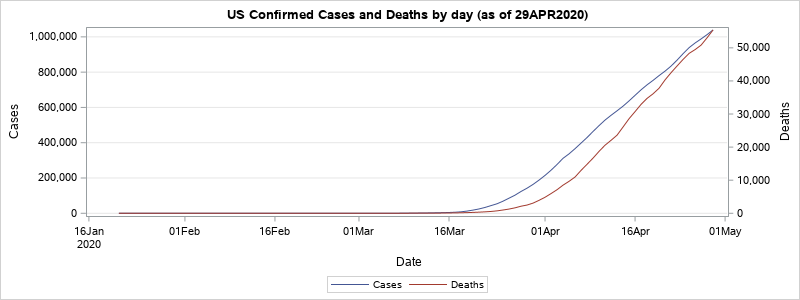

In [14]:
/* 
   SAS program code to fetch and import the COVID-19 data 
   maintained by the New York Times.

   Data source: https://github.com/nytimes/covid-19-data
   
   Copyright 2020, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
   SPDX-License-Identifier: Apache-2.0

   Output: WORK.us_nyt, WORK.us_states_nyt, WORK.us_counties_nyt
*/

/* Utility macro to check if folder is empty before Git clone */ 
%macro FolderIsEmpty(folder);
  %local memcount;
  %let memcount = 0;
	%let filrf=mydir;
	%let rc=%sysfunc(filename(filrf, "&folder."));
  %if &rc. = 0 %then %do;
  	%let did=%sysfunc(dopen(&filrf));
  	%let memcount=%sysfunc(dnum(&did));
  	%let rc=%sysfunc(dclose(&did));
    %let rc=%sysfunc(filename(filrf));
  %end;
  /* Value to return: 1 if empty, else 0 */
  %sysevalf(&memcount. eq 0)
%mend;

/* Run this part just once - creates a temp folder 
   and clones the GitHub repo into it          
 
   This repo will be copied to saswork and will be deleted when the 
   SAS session ends 
*/
/* DLCREATEDIR option will use LIBNAME to create a folder */
options dlcreatedir;
%let repoPath = %sysfunc(getoption(WORK))/NYTimes_COVID-19;
libname repo "&repoPath.";
libname repo clear;
 
/* Fetch latest data from GitHub                      */
/* Note that Git clone fails if folder is not empty   */
/* Git functions avail in SAS 9.4M6 and SAS Viya 3.5  */
 data _null_; 
    if (%FolderIsEmpty(&repoPath.)) then do;
    	rc = gitfn_clone( 
      	"https://github.com/nytimes/covid-19-data", 
      	"&repoPath." 
    				); 
    	put 'Git repo cloned ' rc=; 
    end;
    else put "Skipped Git clone, folder not empty";
 	run; 

/* read the national level data */
data us_nyt;
 length Date 8 Cases 8 Deaths 8
        WeekOf 8;
 format Date date9. WeekOf date9.;
 infile "&repoPath./us.csv" 
   dlm=',' missover dsd firstobs=2;
 input date : yymmdd10.
       cases
       deaths;
  /* Adding Week ending value for easier summary later */
  WeekOf = intnx('week',date,0,'E');
run;

/* Quick visualization of this data */
proc sql noprint;
 select max(date) format=date9. into: asOf
  from us_nyt;
quit;
title "US Confirmed Cases and Deaths by day (as of &asOf.)";
ods graphics / width=800 height=300;
options nocenter;
proc sgplot data=us_nyt;
  series x=date y=cases;
  series x=date y=deaths / yaxis2;
  yaxis grid;
  format cases comma12. deaths comma12.;
run;

,,
,,
,,
,,
,,
,,
,,
,,
,,
,,
,,

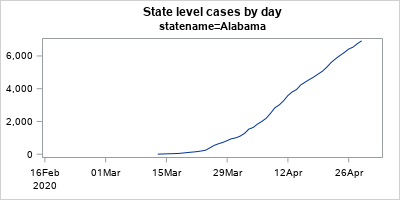
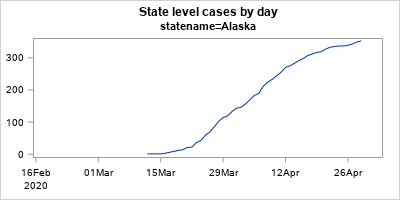
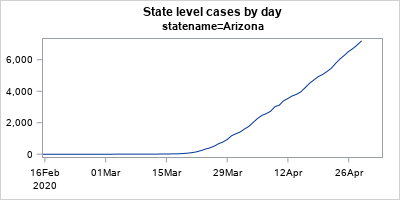
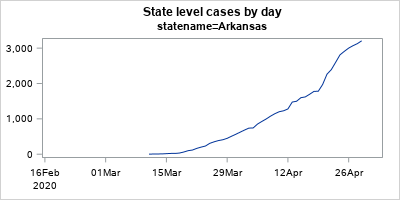
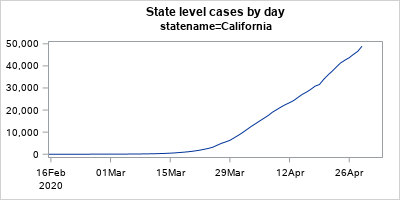
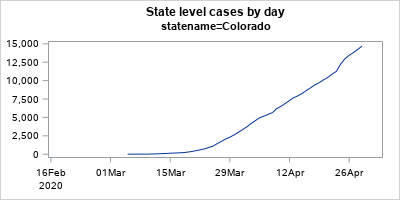
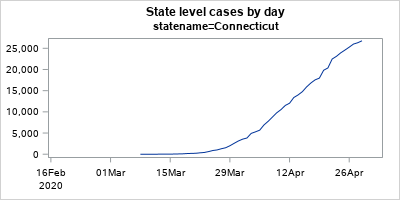
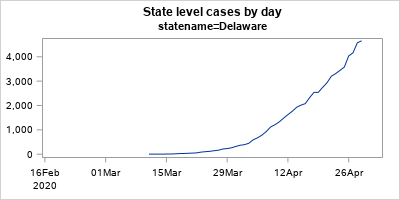
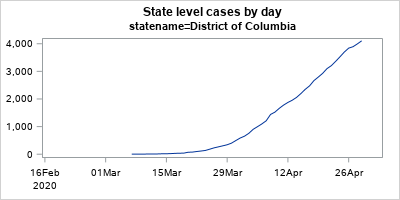
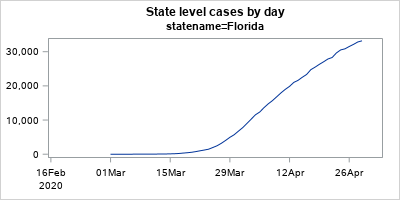
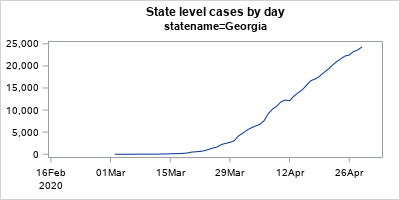
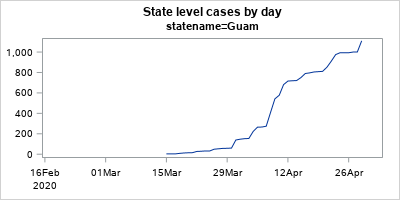
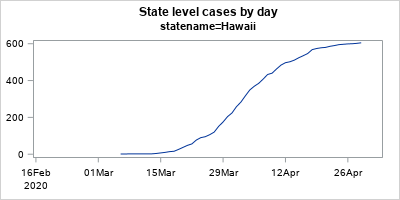
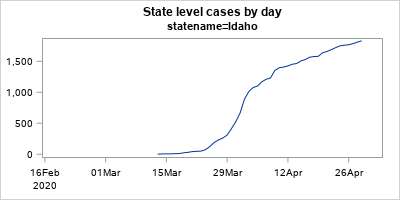
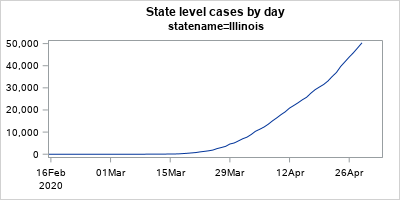
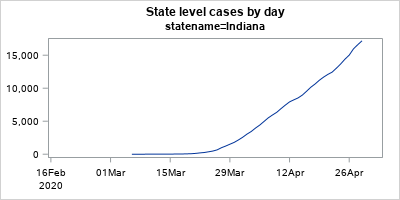
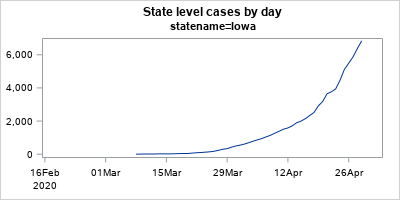
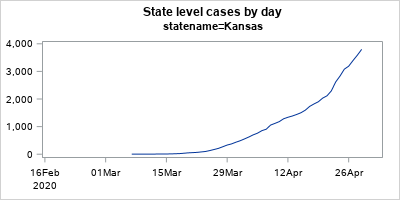
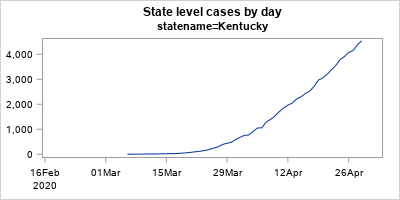
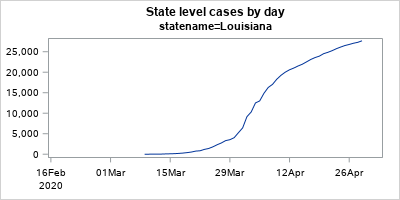
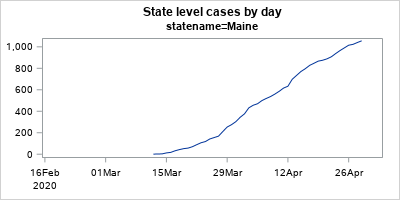
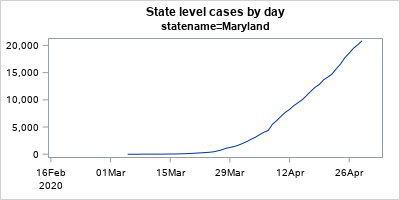
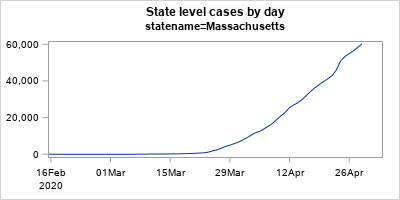
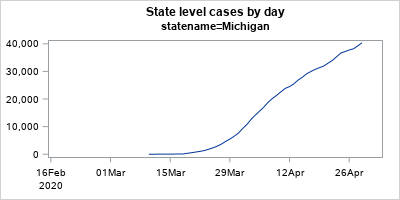
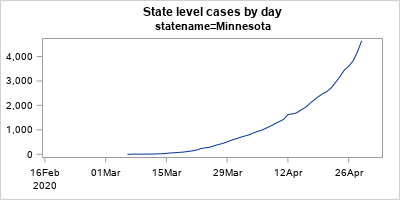
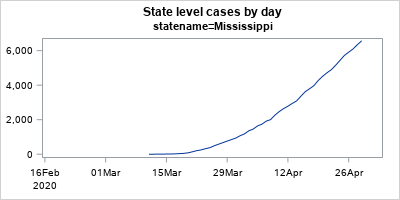
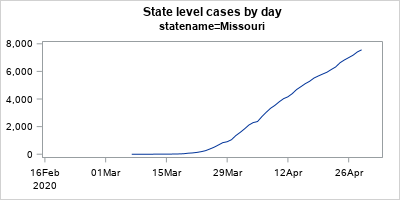
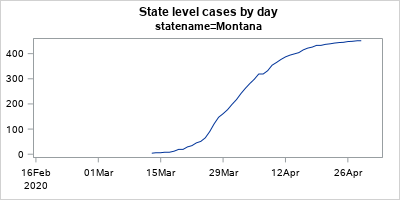
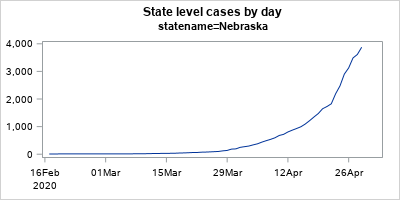
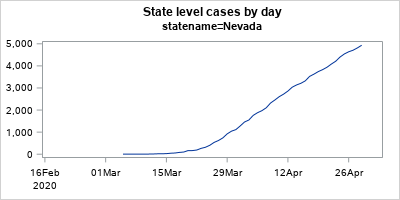
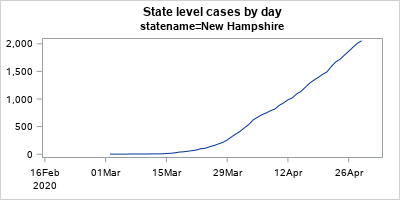
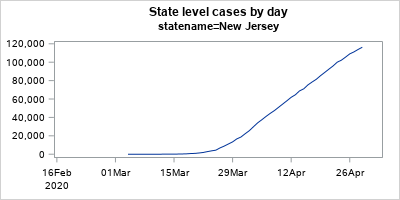
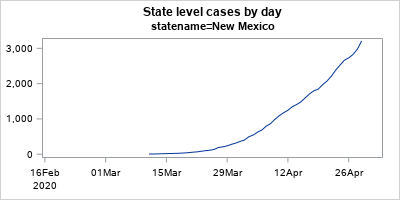
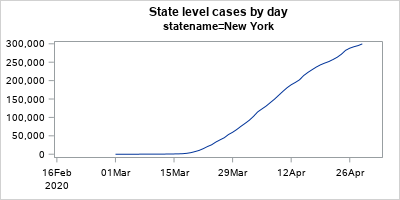
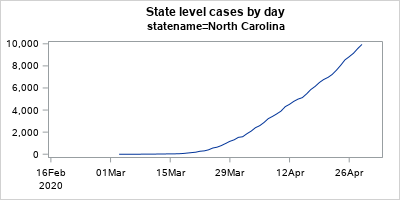
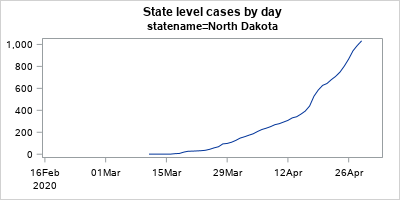
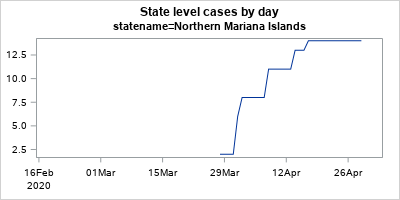
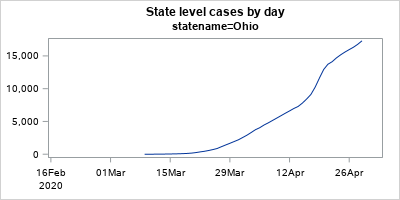
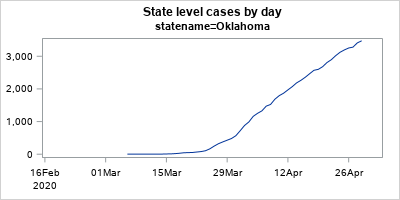
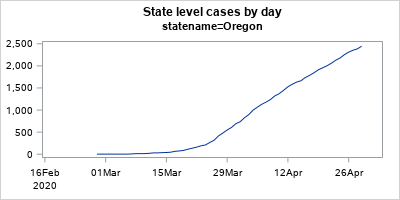
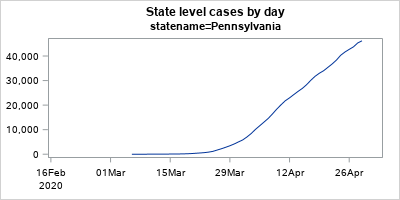
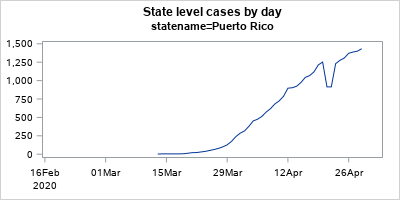
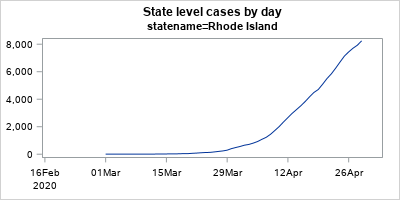
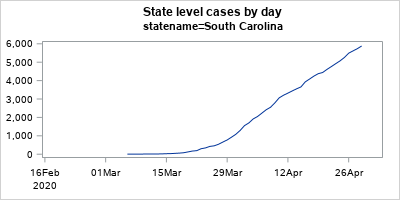
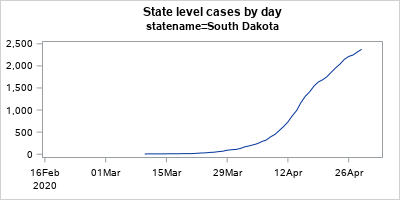
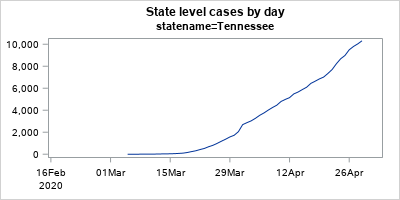
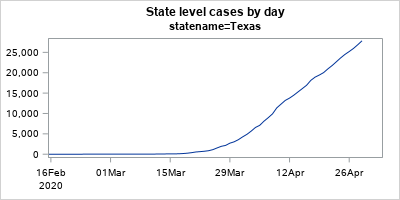
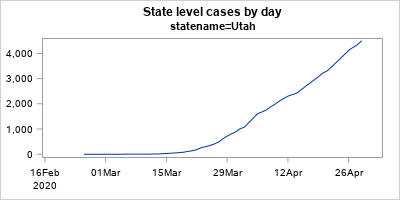
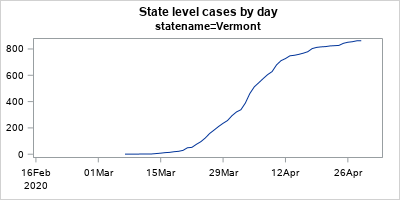
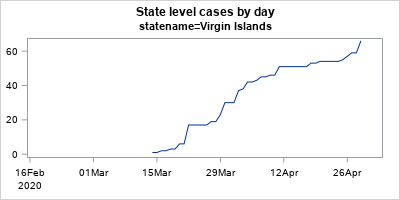
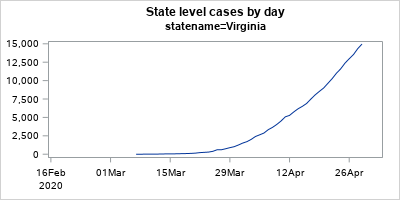
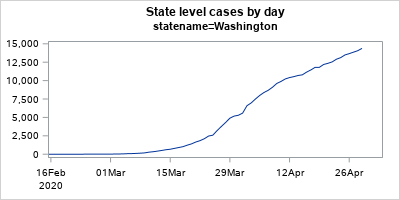
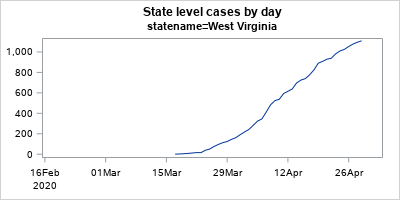
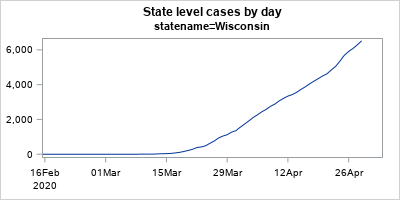
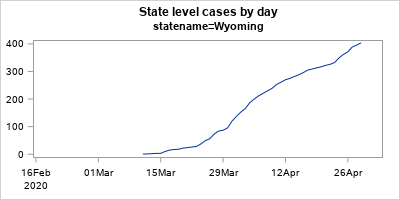

In [24]:
/* read the states level data */
data us_states_nyt;
 length Date 8 statename $ 30 FIPS $ 6 Cases 8 Deaths 8
        WeekOf 8;
 format Date date9. WeekOf date9.;
 infile "&repoPath./us-states.csv" 
   dlm=',' missover dsd firstobs=2;
 input date : yymmdd10.
       statename
       FIPS
       cases
       deaths;
  /* Adding Week ending value for easier summary later */
  WeekOf = intnx('week',date,0,'E');
run;

title "State level cases by day";
/* A quick visualization of all of the states data */
proc sort data=us_states_nyt
 out=us_states_nyt_sorted;
 by statename;
run;

ods html5(id=saspy_internal) gtitle;
ods layout gridded columns=3 advance=bygroup;
ods region;
ods graphics / width=400 height=200;
proc sgplot data=us_states_nyt_sorted;
 series x=Date y=Cases;
 format cases comma12.;
 by statename notsorted;
 xaxis min='16feb2020'd display=(nolabel);
 yaxis display=(nolabel);
run;
ods layout end;

,,
,,
,,
,,
,,
,,
,,
,,
,,
,,
,,

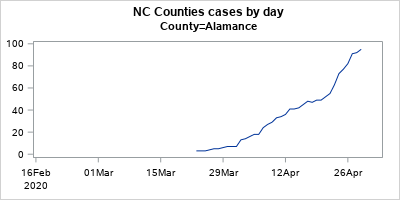
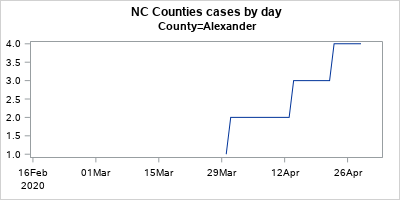
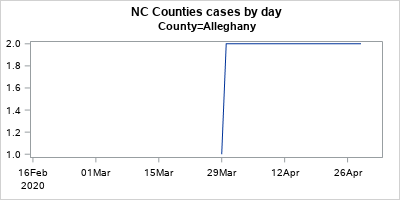
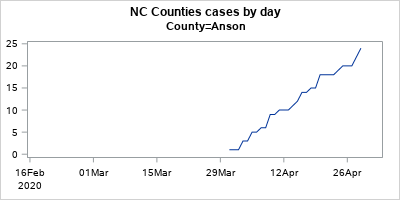
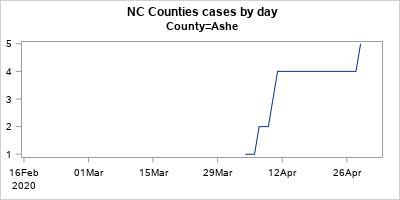
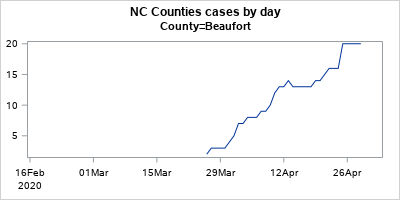
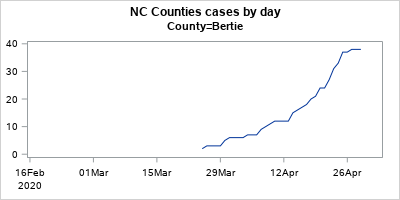
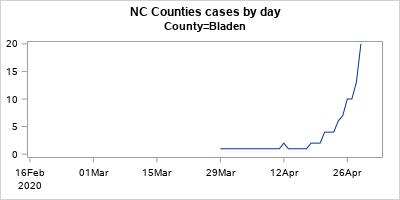
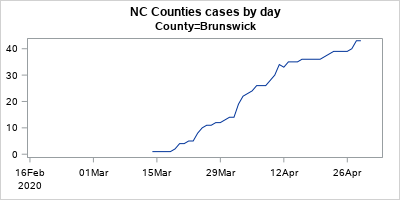
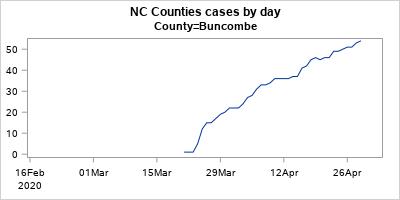
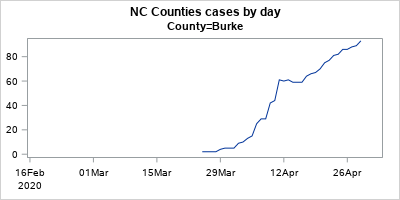
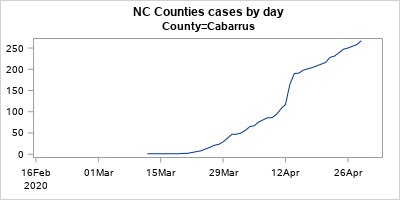
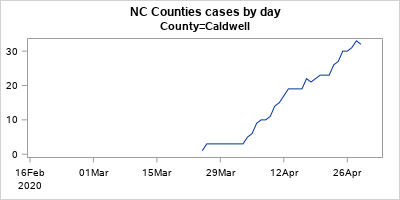
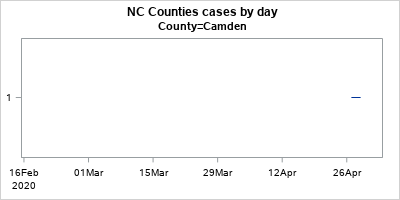
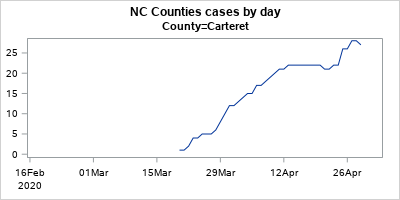
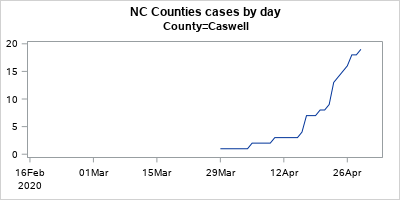
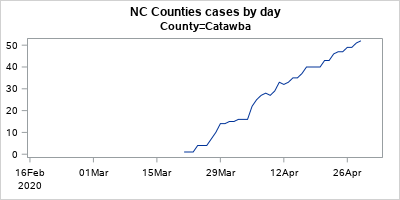
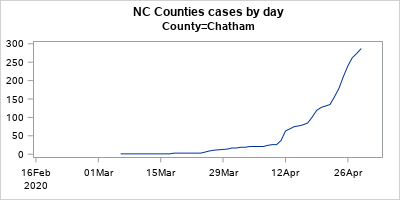
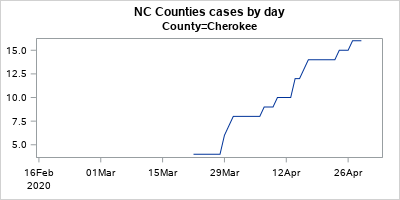
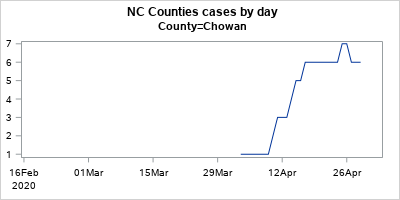
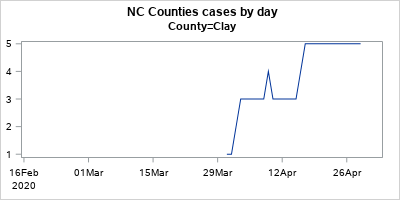
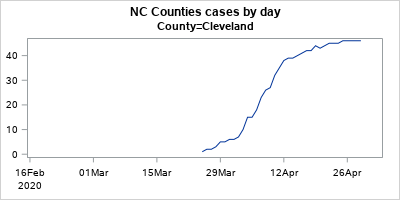
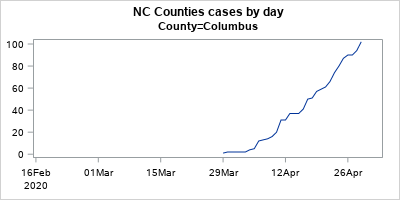
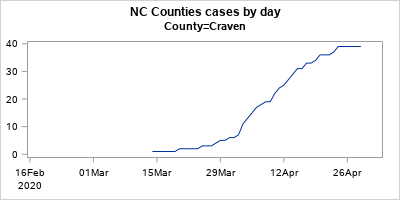
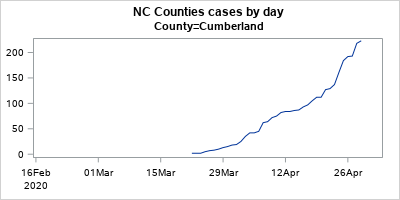
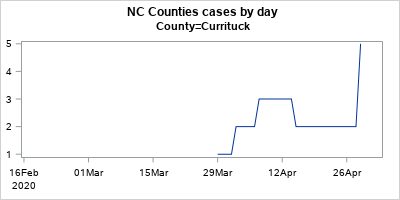
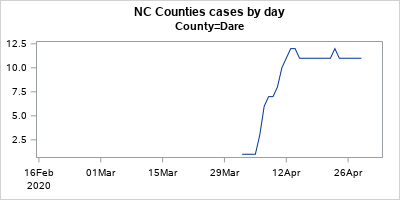
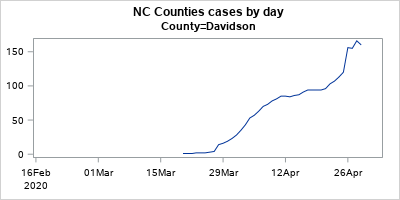
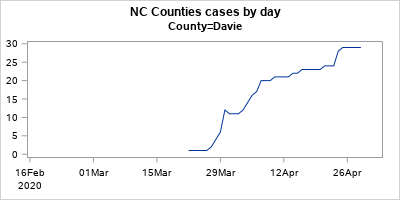
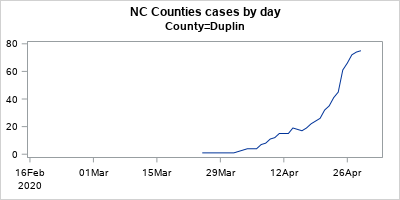
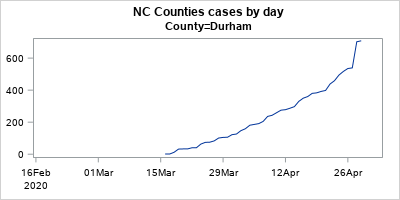
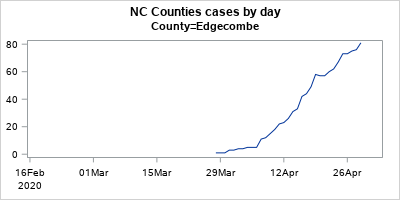
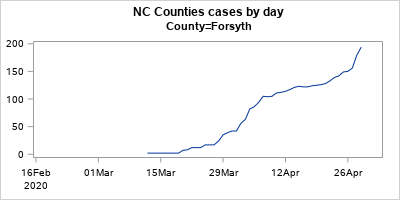
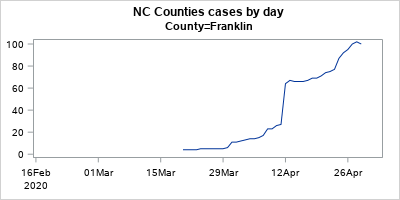
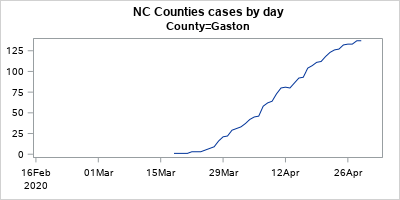
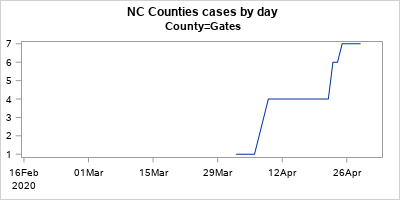
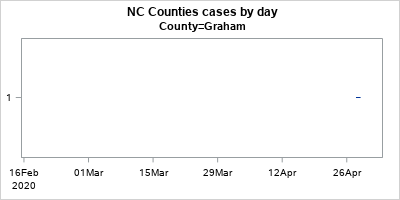
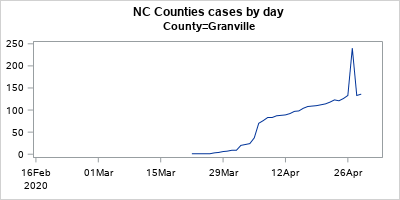
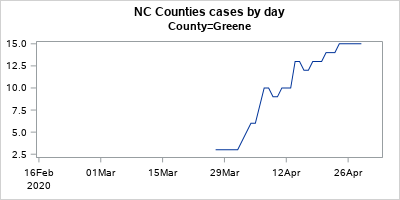
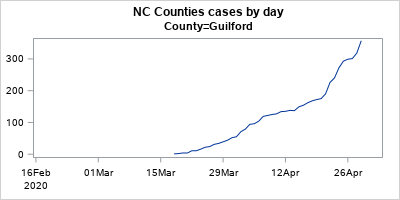
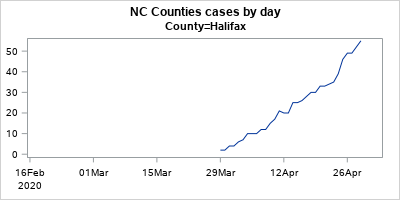
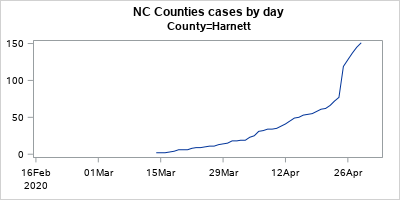
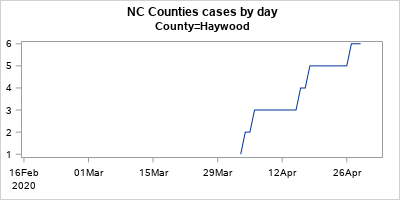
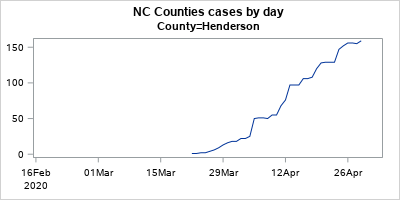
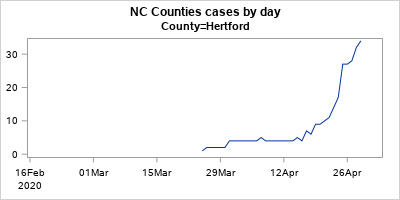
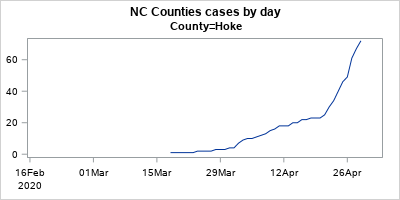
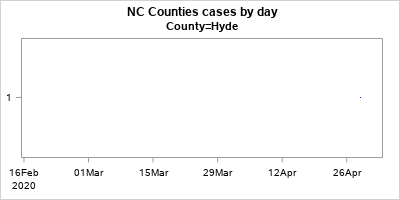
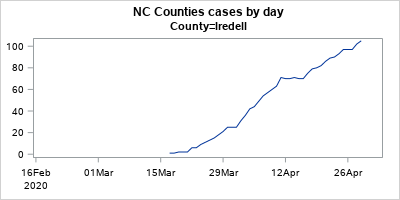
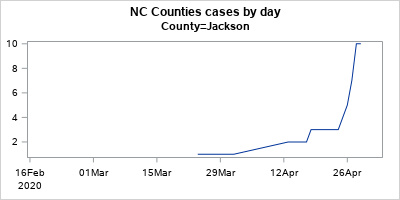
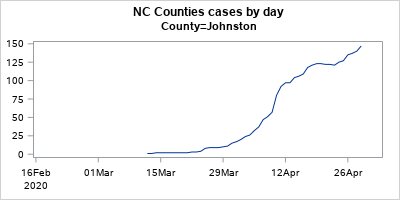
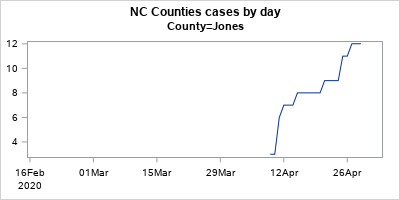
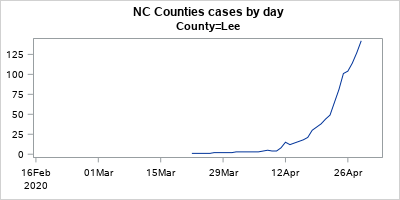
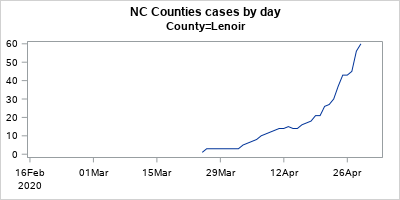
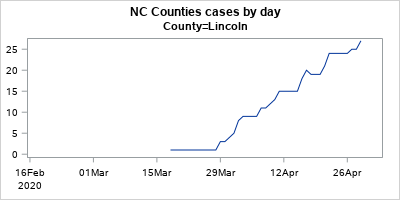
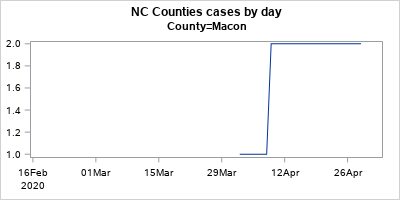
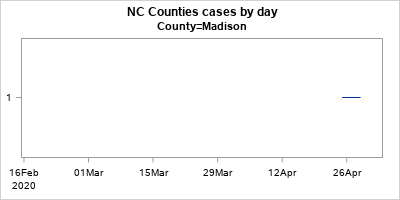
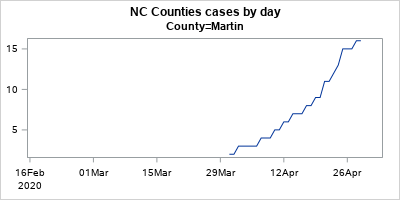
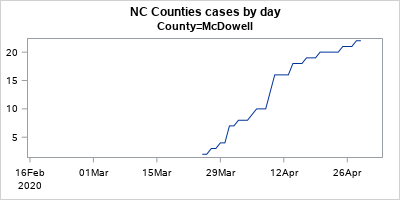
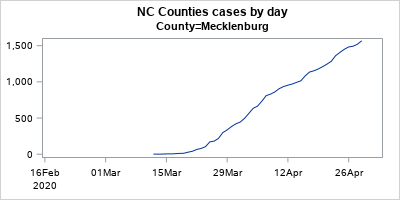
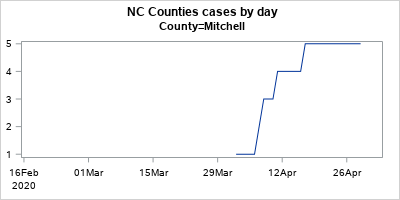
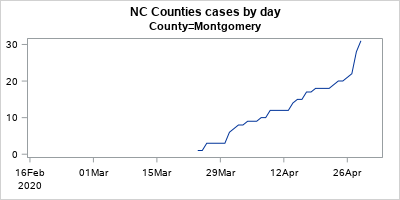
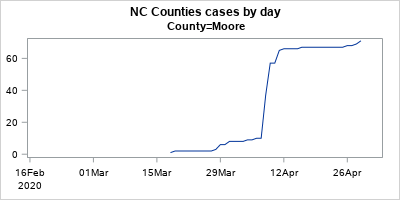
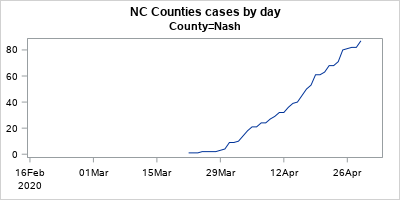
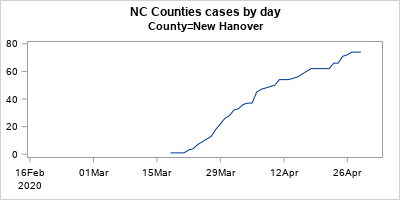
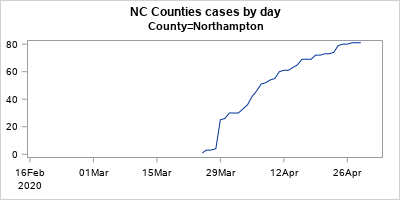
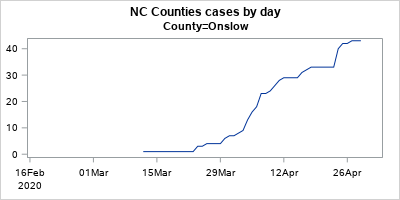
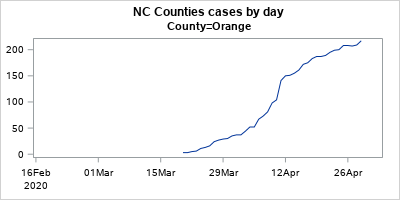
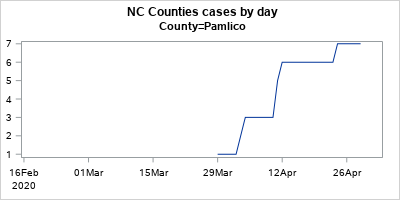
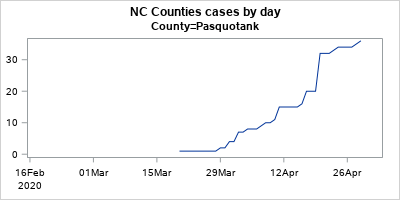
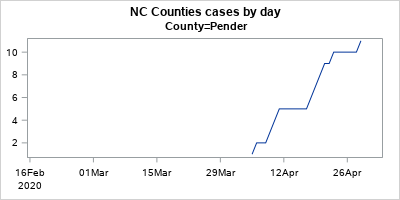
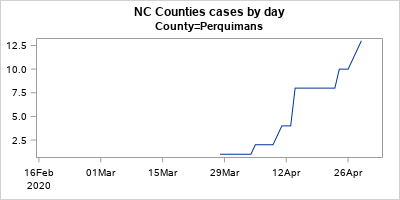
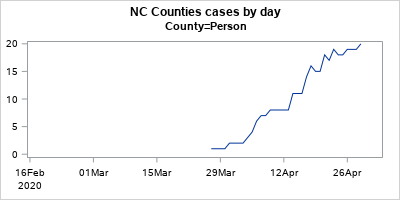
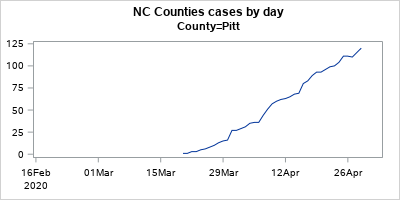
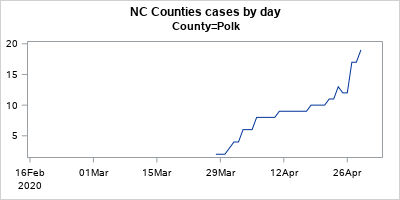
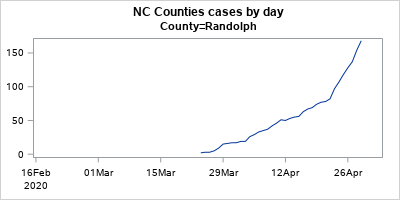
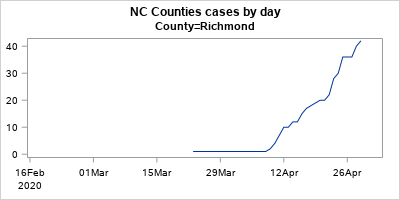
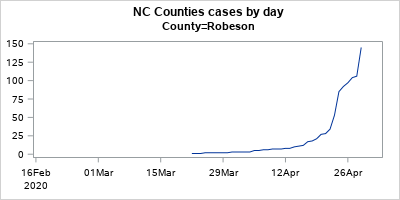
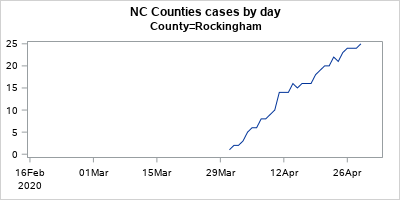
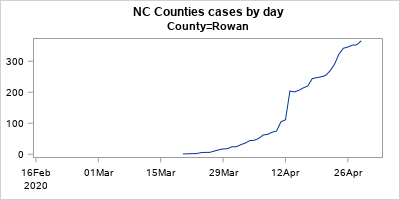
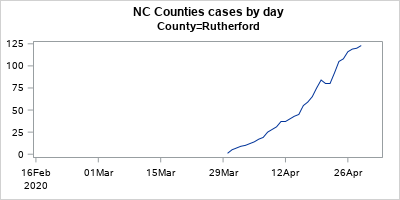
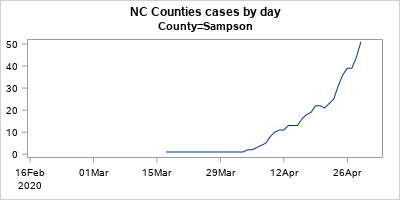
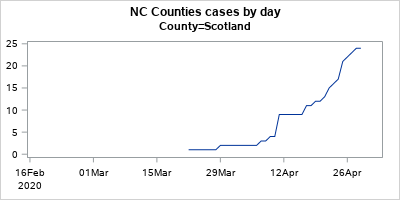
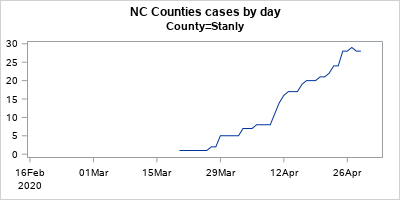
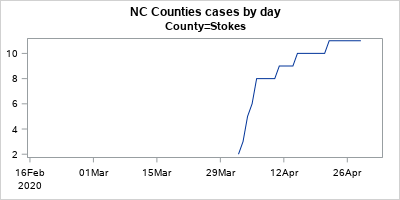
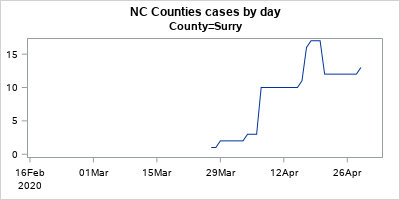
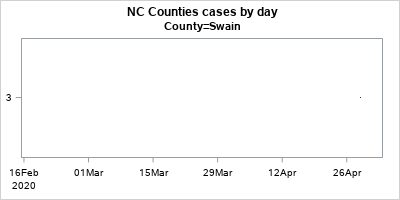
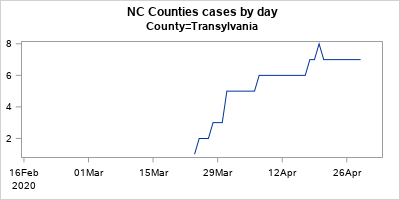
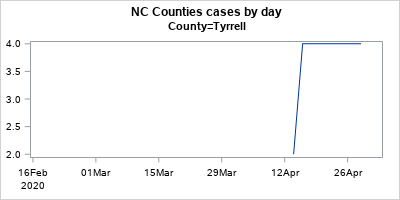
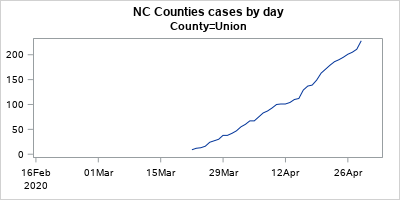
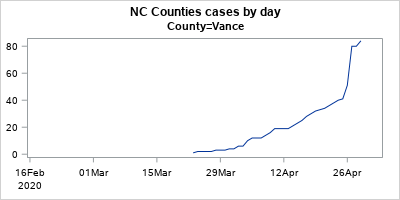
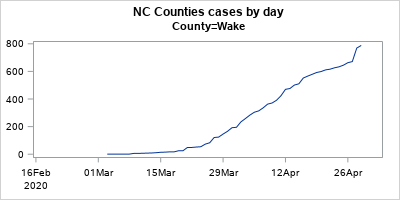
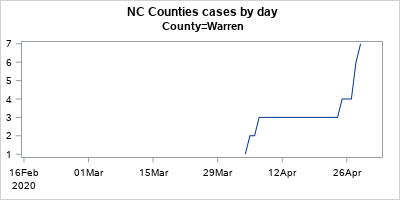
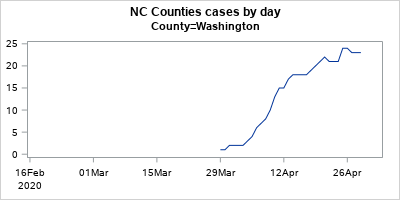
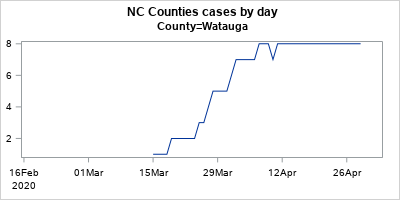
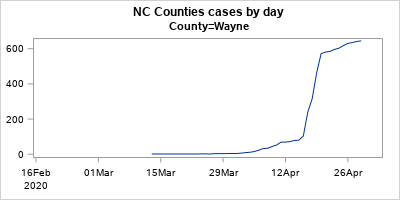
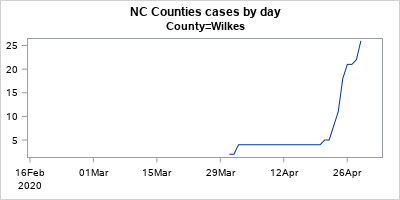
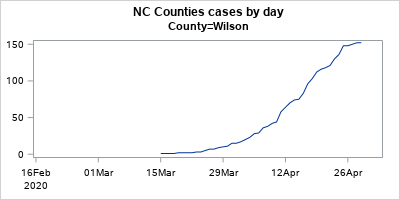
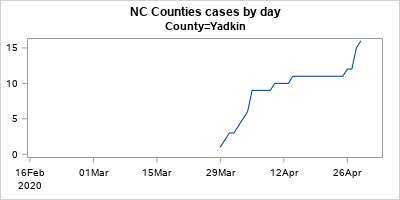

In [23]:
/* read the county level data */
data us_counties_nyt;
 length Date 8 County $ 30 statename $ 30 FIPS $ 6 Cases 8 Deaths 8
        WeekOf 8;
 format Date date9. WeekOf date9.;
 infile "&repoPath./us-counties.csv" 
   dlm=',' missover dsd firstobs=2;
 input date : yymmdd10.
       county
       statename
       FIPS
       cases
       deaths;
 /* Adding Week ending value for easier summary later */
 WeekOf = intnx('week',date,0,'E');
run;

/* A quick visualization of NC county data */
proc sort data=us_counties_nyt
 out=nc_counties;
 by county;
 where statename="North Carolina";
run;

ods html5(id=saspy_internal) gtitle;
ods layout gridded columns=3 advance=bygroup;
ods region;
ods graphics / width=400 height=200;
proc sgplot data=nc_counties;
 series x=Date y=Cases;
 format cases comma12.;
 by county;
 xaxis min='16feb2020'd display=(nolabel);
 yaxis display=(nolabel);
run;
ods layout end;
